# 1. Set up

## 1.1 Environment

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from IPython.display import display

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import sklearn
import re

import statsmodels.api as sm 
import seaborn as sns
sns.set_style('whitegrid')

from __future__ import division
from math import *
from scipy import integrate
from numpy import inf
from sklearn import mixture, neighbors 

from windrose import WindroseAxes, WindAxes

from helpers.utility_helper import *
from helpers.app_helper import *
from helpers.gmm_helper import *
from helpers.plot_helper import *
from helpers.data_reader import *

## 1.2 Read Data

In [2]:
# ipath= './data/NCDC/uk/boscombe_down/dat.txt' # weird shape at 3, try 4
# ipath= './data/NCDC/tiree.txt'
# ipath= "./data/NCDC/marham.txt"

# ipath= "./data/NCDC/cheongju_intl/dat.txt"

ipath= "./data/NCDC/canada/melita_man/dat.txt" 
# ipath= "./data/NCDC/canada/fort_smith/dat.txt"  # lacks inital speed
# ipath= "./data/NCDC/canada/mildred_lake_alta/dat.txt"  # uptail wind speed 

# ipath= './data/NCDC/europe/ciampino/dat.txt' # Italy
# ipath= "./data/NCDC/europe/laupheim/dat.txt"
# ipath= "./data/NCDC/europe/holzdorf/dat.txt"
# ipath= "./data/NCDC/europe/neuburg/dat.txt"
# ipath= "./data/NCDC/europe/landsberg_lech/dat.txt"
# ipath= "./data/NCDC/europe/valladolid/dat.txt"
# ipath= "./data/NCDC/europe/vatry/dat.txt"  # double peak, try 4
# ipath= "./data/NCDC/europe/avord/dat.txt" # double peak. recent year data maybe corrputed
# ipath= "./data/NCDC/europe/salamanca/dat.txt" # recent 5 year is truncate data, before is better
# ipath= "./data/NCDC/europe/barayas/dat.txt" # try 4, still bad fit
# ipath= "./data/NCDC/europe/huspel_aws/dat.txt"  # integer
# ipath= "./data/NCDC/europe/diepholz/dat.txt" # recent year is integer

# ipath= "./data/NCDC/dr_ambedkar_intl/dat.txt" # India, not very good

# ipath= "./data/NCDC/south_america/senador_petronio/dat.txt" # unable to chi square
# ipath= "./data/NCDC/south_america/ambrosio_lv/dat.txt" # sectors are 16

# ipath= "./data/NCDC/oceania/narrandera/dat.txt" 
# ipath= "./data/NCDC/oceania/brisbane_archerfield/dat.txt" 
# ipath= "./data/NCDC/oceania/brisbane/dat.txt" # bad fit
# ipath= "./data/NCDC/oceania/auckland/dat.txt"  # Weird KDE shape

# ipath= "./data/NCDC/cn/luogang/dat.txt"  # good
# ipath= "./data/NCDC/cn/南京lukou/dat.txt" # good
# ipath= "./data/NCDC/cn/binhai/dat.txt" # good, but recent 5 year data may have been corrupted, 05-09 is good
# ipath= "./data/NCDC/cn/郑州xinzheng/dat.txt" # 
# ipath= "./data/NCDC/cn/zhengding/dat.txt" # 
# ipath= "./data/NCDC/cn/武汉tianhe/dat.txt" # 
# ipath= "./data/NCDC/cn/wusu/dat.txt" # not quite good, try 4?
# ipath= "./data/NCDC/cn/gushi/dat.txt" # 16 sectors, some direction deviate big
# ipath= "./data/NCDC/cn/yueyang/dat.txt" # 16 sectors, some direction deviate big
# ipath= "./data/NCDC/cn/wuxu/dat.txt" # unable to fit with chi square
# ipath= "./data/NCDC/cn/广州baiyun/dat.txt" # Is this dataset correct?

# ipath= "./data/NCDC/cn/baoan_intl/dat.txt" # good, but 1个方向的数据过少，很难拟合
# ipath= "./data/NCDC/cn/上海/虹桥/dat.txt" # good
# ipath= './data/NCDC/macau/dat.txt' # not good, feels like truncate data, try 4
# ipath= "./data/NCDC/hk_intl/dat.txt" # truncate dataset

## US dataset, is mostly over a threshold, low wind speed is not complete
# ipath= "./data/NCDC/us/sheboygan/dat.txt" # untruncate us dataset, but recent 5 year maybe corrupted
# ipath= "./data/NCDC/us/sacramento_arp/dat.txt"  # truancate data
# ipath= "./data/NCDC/us/st_louis_arp/9511346969491dat.txt"  
# ipath= './data/NCDC/us/huron/3461896967321dat.txt'
# ipath= "./data/NCDC/us/baltimore/9963956959409dat.txt"
# ipath= './data/NCDC/us/kennedy/5807936958436dat.txt'
# ipath= './data/NCDC/us/newark/8455636958433dat.txt'
# ipath= './data/NCDC/us/la_guardia/1057036958434dat.txt'
# ipath= "./data/NCDC/us/olympia_airport/2647036962786dat.txt" 
# ipath= "./data/NCDC/us/sidney/6062326959357dat.txt" 
# ipath= "./data/NCDC/us/general_mitchell_intl/dat.txt"

# not sample as %5, e.g. sampling time is 1852
# ipath= "./data/NCDC/us/quad_city_arp/dat.txt" 

# ipath= "./data/cn_database/beijing.txt"
# ipath= "./data/cn_database/xiamen.txt"
# ipath= "./data/cn_database/hefei.txt"
# ipath= "./data/cn_database/lasa.txt"
# ipath= "./data/cn_database/lenghu.txt"

## Problem dataset
# ipath= "./data/NCDC/canada/stony_rapids_arpt/dat.txt" # truncate data
# ipath= './data/NCDC/europe/tenerife_sur/dat.txt'  # recent year speed wired
# ipath= "./data/NCDC/south_america/carlos_ibanez/dat.txt" # bad dataset, direction
# ipath= "./data/NCDC/south_america/rio_cuarto/dat.txt"  # bad dataset
# ipath= "./data/NCDC/south_america/senador_nilo/dat.txt" # bad dataset, direction 
# ipath= "./data/NCDC/cn/长沙huanghua/dat.txt" # direction may not be real

uipath = unicode(ipath , "utf8")
cn_database = False

if not "cn_database" in ipath: 
    df = pd.read_csv(uipath,header=0, skipinitialspace=True)
    df.rename(columns={'Date':'date','Dir':'dir','Spd':'speed','Type':'type'}, inplace=True)
    df = df[['date','HrMn','type','dir','speed' ]]
else:
    df = read_cn_database(uipath)
    cn_database = True

In [3]:
# select year 1945-2014, dir < 999, speed<999
df = df.query("(dir < 999) & (speed < 999) & \
              (date >= 19800000) & (date < 20160000) & \
              (HrMn % 5 == 0 )")

# Turn dir into [0,360), some station are[10,360],some are [0,350]
df.index= df['date']
df['dir'] = df['dir'].apply(lambda x: x%360)
df.describe()

,date,HrMn,dir,speed
count,155112.000000,155112.000000,155112.000000,155112.000000
mean,20054489.559035,1133.827170,191.723490,4.176262
std,69446.569880,692.935463,102.936667,2.356673
min,19900724.000000,0.000000,0.000000,0.000000
25%,20020528.000000,600.000000,110.000000,2.500000
50%,20061219.000000,1100.000000,190.000000,3.600000
75%,20110711.000000,1700.000000,280.000000,5.600000
max,20151231.000000,2300.000000,350.000000,19.500000


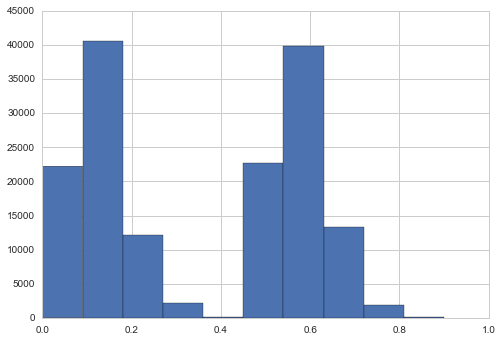

In [4]:
# Detect data stored in knot or m/s
df['decimal'] = df.speed % 1 
df.decimal.hist()
knot_unit = True if len(df.query('decimal >= 0.2'))/len(df) > 0.3 else False

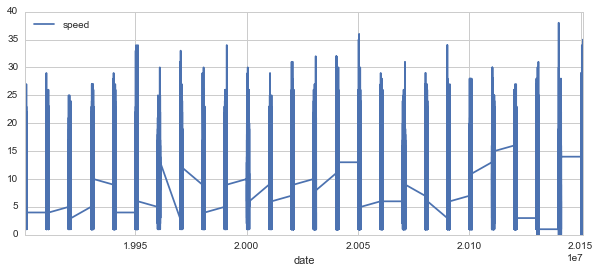

In [5]:
# Using speed unit in knot instead of m/s
# need more elaboration, some is not near an integer
if knot_unit:
    df.rename(columns={'speed':'speed_mps'}, inplace=True)
    df['speed']=df['speed_mps']
    df['speed']=df['speed_mps']*1.943845
    df['speed']=df['speed'].apply(lambda x: int(round(x)))

df['speed'].plot(legend=True,figsize=(10,4), grid=True)

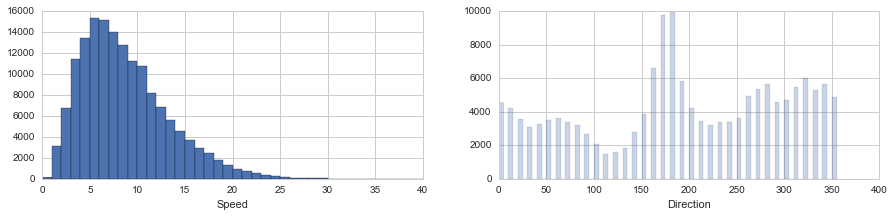

In [6]:
# Notice the gap of the distributions, so futher process needed, as below
plot_speed_and_angle_distribution(df)

## 1.3 Data Wrangling

### 1.3.1 Artefacts handling

,date,HrMn,type,dir,speed_mps,decimal,speed,incre,incre_reverse
date,,,,,,,,,
20140116,20140116,900,SAO,340,19.5,0.5,38,4,15
20140116,20140116,700,SAO,340,19.0,0.0,37,4,3
20140116,20140116,1100,SAO,340,19.0,0.0,37,14,1
20050522,20050522,400,SAO,300,18.5,0.5,36,9,0
20140116,20140116,1200,FM-12,350,18.5,0.5,36,-1,13
20050522,20050522,500,SAO,310,18.5,0.5,36,0,5
20050310,20050310,1100,SAO,340,18.0,0.0,35,4,3
20151118,20151118,2200,SAO,320,18.0,0.0,35,5,5
20140116,20140116,400,SAO,320,18.0,0.0,35,6,2


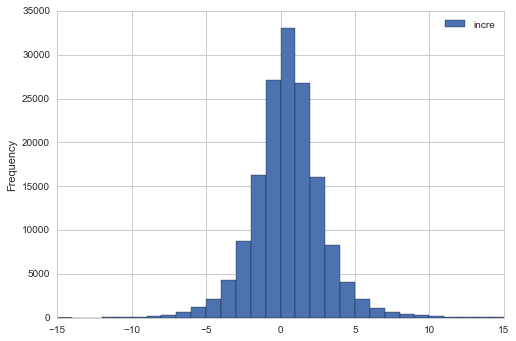

In [7]:
df['incre'] = df.speed.diff(1)
df['incre'].fillna(0)
df['incre_reverse'] = df.speed.diff(-1)
df['incre_reverse'].fillna(0)
display(df.sort_values(by='speed',ascending=False).head(10))
bins=np.arange(-15, 15 + 1, 1)
df['incre'].plot(kind='hist', bins=bins, legend=True)

In [8]:
# Simple Artefacts Handling
incre_threshold = 20 if knot_unit else 10
df = df.query('(incre < @incre_threshold )&(incre_reverse < @incre_threshold )')
df = df.query('dir % 10 <= 0.1')

After Simple Aretefacts Handling

In [9]:
# Check the max speed
df.sort_values(by='speed',ascending=False).head(10)

,date,HrMn,type,dir,speed_mps,decimal,speed,incre,incre_reverse
date,,,,,,,,,
20140116,20140116,900,SAO,340,19.5,0.5,38,4,15
20140116,20140116,1100,SAO,340,19.0,0.0,37,14,1
20140116,20140116,700,SAO,340,19.0,0.0,37,4,3
20140116,20140116,1200,FM-12,350,18.5,0.5,36,-1,13
20050522,20050522,500,SAO,310,18.5,0.5,36,0,5
20050522,20050522,400,SAO,300,18.5,0.5,36,9,0
20140116,20140116,400,SAO,320,18.0,0.0,35,6,2
20151118,20151118,2200,SAO,320,18.0,0.0,35,5,5
20050310,20050310,1100,SAO,340,18.0,0.0,35,4,3


### 1.3.2 Sampling Time Selection

In [10]:
df['HrMn'].value_counts().sort_index()

0       8470
100     5945
200     5977
300     6350
400     5991
500     6001
600     8472
700     5983
800     6010
900     6388
1000    6033
1100    6007
1200    8437
1300    5996
1400    5972
1500    6358
1600    5981
1700    5973
1800    8437
1900    5961
2000    5986
2100    6358
2200    5970
2300    5960
Name: HrMn, dtype: int64

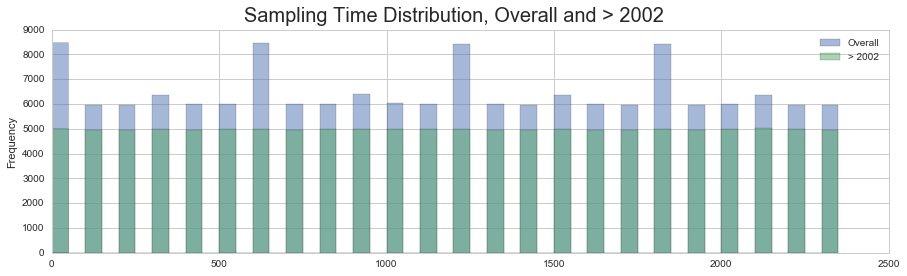

In [11]:
# Ensure data sampled equally
mid_year = int(((min(df.date)+max(df.date))/2 )/10000)
bins=np.arange(min(df.HrMn), max(df.HrMn) + 100, 50)

df['HrMn'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='Overall')

df.query('date > @mid_year * 10000')['HrMn'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='> %s' %  mid_year )

plt.suptitle('Sampling Time Distribution, Overall and > %s ' %  mid_year, fontsize = 20)
plt.legend()

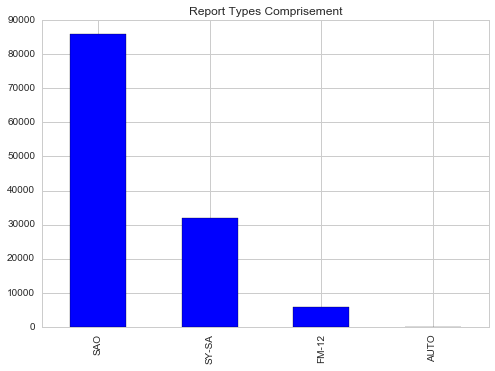

In [12]:
df.query("date >= 20000000 ")['type'].value_counts().plot(
    kind = 'bar', title = 'Report Types Comprisement')

report_type_most_used = df.query("date >= 20000000 ")['type'].value_counts().argmax()

In [13]:
# Data Selection
if "ciampino" in ipath: 
    df = df[(df['HrMn'] % 100 == 15)|(df['HrMn'] % 100 == 45)|(df['HrMn'] % 100 == 20)|(df['HrMn'] % 100 == 50)]
else: 
    df = df.query('HrMn % 5 <= 0.1')

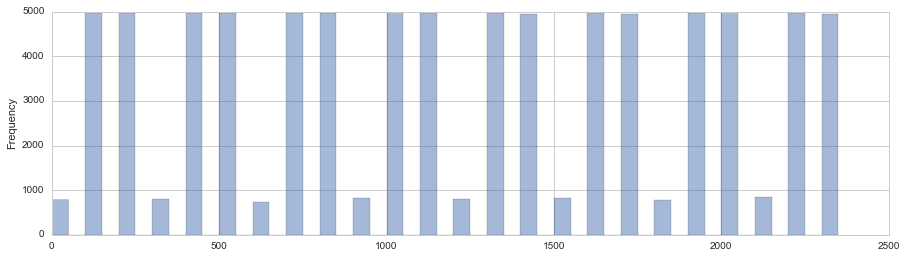

In [14]:
# We're gonna use the most frequent report type, here is its distirbution
df = df.query("type==@report_type_most_used")

df.query('date > 20000000')['HrMn'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins)

## 1.3.3 Time Shift Comparison

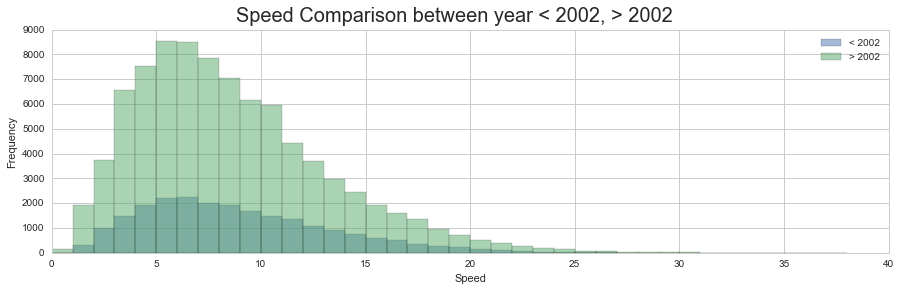

In [15]:
mid_year = int(((min(df.date)+max(df.date))/2 )/10000)

# Comparison between mid_year, looking for: 
# 1. Odd Even Bias
# 2. Time Shift of Wind Speed Distribution
bins = np.arange(min(df.speed), max(df.speed) + 1, 1)
df[df['date'] < mid_year * 10000]['speed'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='< %s' % mid_year)

df[df['date'] > mid_year * 10000]['speed'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='> %s' % mid_year)

plt.xlabel("Speed")
plt.suptitle('Speed Comparison between year < %s, > %s ' % (mid_year, mid_year), fontsize = 20)
plt.legend()

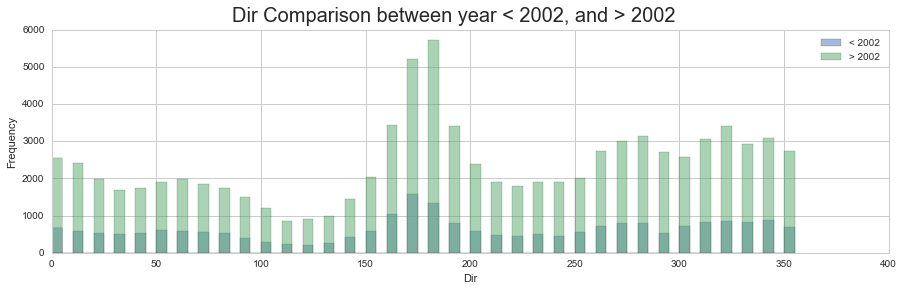

In [16]:
bins=np.arange(min(df.dir), max(df.dir) + 10, 5)
df[df['date'] < mid_year * 10000]['dir'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='< %s' % mid_year)

df[df['date'] > mid_year * 10000]['dir'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='> %s' % mid_year)

plt.xlabel("Dir")
plt.suptitle('Dir Comparison between year < %s, and > %s ' % (mid_year, mid_year), fontsize = 20)
plt.legend()

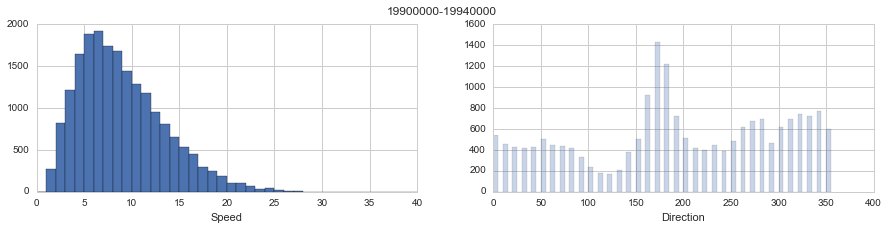

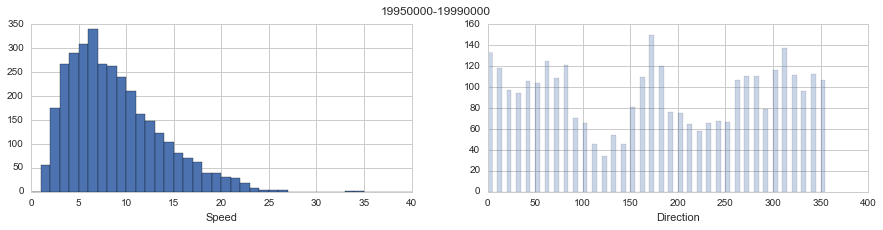

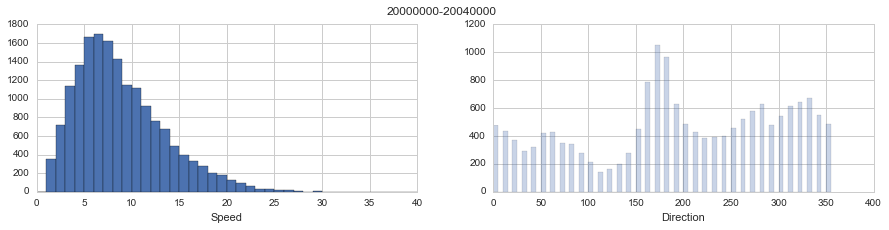

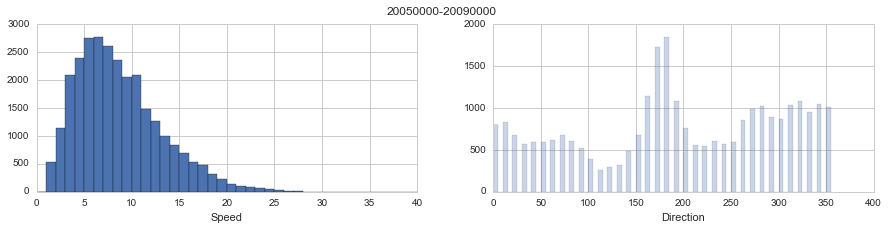

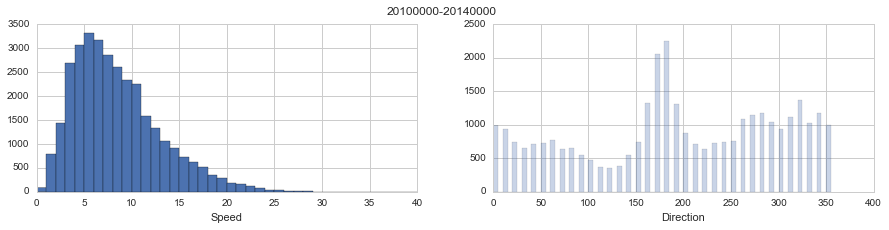

In [17]:
# Inspect the time shift of speed and degree distribution, and odd-even bias
def check_time_shift(df):
    for start_time in xrange(19850000, 20150000, 50000):
        end_time = start_time + 50000 
        sub_df = df.query('(date >= @start_time) & (date < @end_time)')
        if len(sub_df) > 0 :
            title = str(start_time) +'-' + str(end_time-10000)
            plot_speed_and_angle_distribution(sub_df, title)
        
check_time_shift(df)

## 1.4 Re-select data, data conversion, and overview of the clean dataset

In [18]:
# Year range, Reports Type, Sampling Time
df = df.query('(date >= 20100000) & (date < 20150000)')
df.describe()

,date,HrMn,dir,speed_mps,decimal,speed,incre,incre_reverse
count,32719.000000,32719.000000,32719.000000,32719.00000,32719.000000,32719.000000,32719.000000,32719.000000
mean,20122597.961918,1181.820960,191.404688,4.06918,0.339726,7.962682,-0.000122,-0.005104
std,14330.119724,690.330973,102.902323,2.36189,0.260584,4.590444,2.182417,2.180008
min,20100101.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-17.000000,-22.000000
25%,20110605.000000,600.000000,110.000000,2.50000,0.100000,5.000000,-1.000000,-1.000000
50%,20121102.000000,1100.000000,190.000000,3.60000,0.500000,7.000000,0.000000,0.000000
75%,20131226.000000,1700.000000,280.000000,5.10000,0.600000,10.000000,1.000000,1.000000
max,20141231.000000,2300.000000,350.000000,19.50000,0.900000,38.000000,18.000000,18.000000


### 1.4.1 Overview

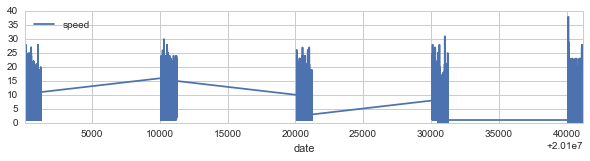

In [19]:
df['speed'].plot(legend=True,figsize=(10,2), grid=True)

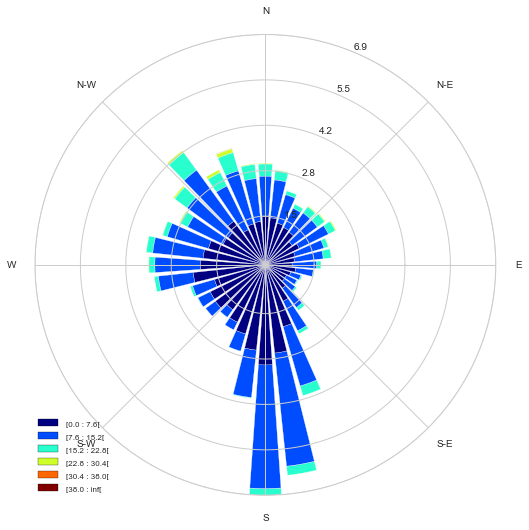

In [20]:
df.dir_windrose = df.dir
# 90 degree is in east
ax = WindroseAxes.from_ax()
ax.bar(df.dir_windrose, df.speed, normed=True, opening=0.8, edgecolor='white', nsector=36)
ax.set_legend()

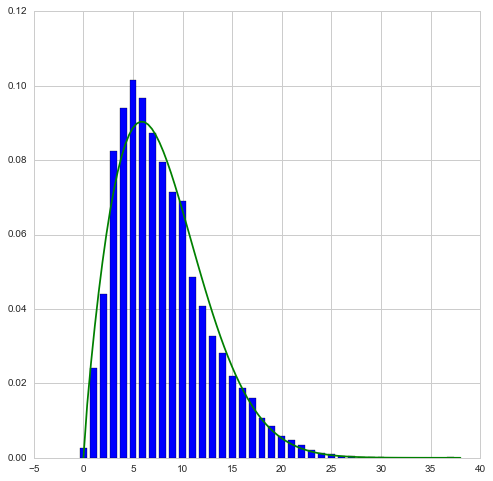

In [21]:
ax = WindAxes.from_ax()
bins=np.arange(min(df.speed), max(df.speed) + 1, 1)
ax, params = ax.pdf(df.speed, bins = bins)

In [22]:
print params
weibull_params = sp.stats.exponweib.fit(df.speed, floc=0, f0=1)
print weibull_params

(1, 1.8392207041789539, 0, 9.013239612718472)
(1, 1.8392207041789539, 0, 9.013239612718472)


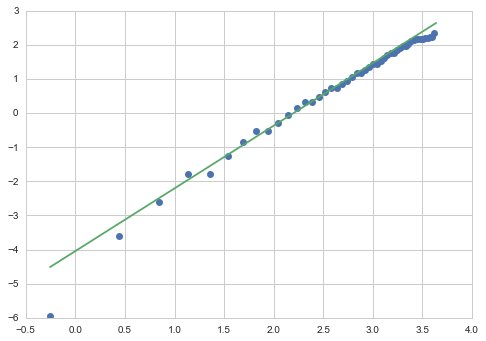

In [23]:
sample = df.speed
ecdf = sm.distributions.ECDF(sample)

x = np.linspace(min(sample), max(sample))
y = ecdf(x)
plt.plot(np.log(x), np.log(-np.log(1-y)),'o')

w_scale, c_shape = weibull_params[1], weibull_params[3]
qz=np.exp(-(x/c_shape)**w_scale)
plt.plot(np.log(x), np.log(-np.log(qz)),'-')
plt.show()

### 1.4.2 Direction Conversion, from windrose to polar system
e.g. 0 degree = north, clockwise => 90 degree = north, counterclockwise

In [24]:
df['dir'] = df['dir'].apply(lambda x: (90 - x)%360)

In [25]:
df['dir'].value_counts().sort_index()

0       544
10      647
20      642
30      769
40      724
50      710
60      659
70      751
80      931
90      992
100     993
110    1182
120    1033
130    1378
140    1110
150     936
160    1046
170    1170
180    1140
190    1089
200     762
210     737
220     723
230     636
240     707
250     878
260    1308
270    2248
280    2065
290    1328
300     749
310     549
320     380
330     351
340     373
350     479
Name: dir, dtype: int64

In [26]:
effective_coloumn = df['dir'].value_counts()[df['dir'].value_counts() > 30].sort_index()

if len(effective_coloumn) == 16:
    # For some dataset, the angle is not evenly distributed, so there is a need to redistribute
    original_angle = list(effective_coloumn.sort_index().index)
    redistributed_angle = np.linspace(0,360,num=17)[:-1]
    df['dir'].replace(to_replace=original_angle, value=redistributed_angle, inplace=True)
    display(df['dir'].value_counts().sort_index())

In [27]:
df.describe()

,date,HrMn,dir,speed_mps,decimal,speed,incre,incre_reverse
count,32719.000000,32719.000000,32719.000000,32719.00000,32719.000000,32719.000000,32719.000000,32719.000000
mean,20122597.961918,1181.820960,177.515816,4.06918,0.339726,7.962682,-0.000122,-0.005104
std,14330.119724,690.330973,93.692300,2.36189,0.260584,4.590444,2.182417,2.180008
min,20100101.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-17.000000,-22.000000
25%,20110605.000000,600.000000,100.000000,2.50000,0.100000,5.000000,-1.000000,-1.000000
50%,20121102.000000,1100.000000,180.000000,3.60000,0.500000,7.000000,0.000000,0.000000
75%,20131226.000000,1700.000000,270.000000,5.10000,0.600000,10.000000,1.000000,1.000000
max,20141231.000000,2300.000000,350.000000,19.50000,0.900000,38.000000,18.000000,18.000000


### 1.4.3 Re-distribute Direction, within each sector (optional)
e.g. Dir 50 -> -45 ~ 55, to make KDE result better

In [28]:
sector_length = 360/len(effective_coloumn)
print len(effective_coloumn), sector_length

def randomize_angle(df, sector_length = 10):
    df['dir_ran'] = df['dir'].apply(lambda x: (x + np.random.uniform(-sector_length/2,sector_length/2))% 360)

    bins=np.arange(0, 360+10, 5)
    df['dir'].hist(bins=bins, alpha=0.5,figsize=(15, 6))
    bins=np.arange(0, 360+10, 1)
    df['dir_ran'].hist(bins=bins, alpha=0.5,figsize=(15, 6))
    
    df['dir']=df['dir_ran']
    df.drop(['dir_ran'], 1,inplace=True)
    return df

36 10.0


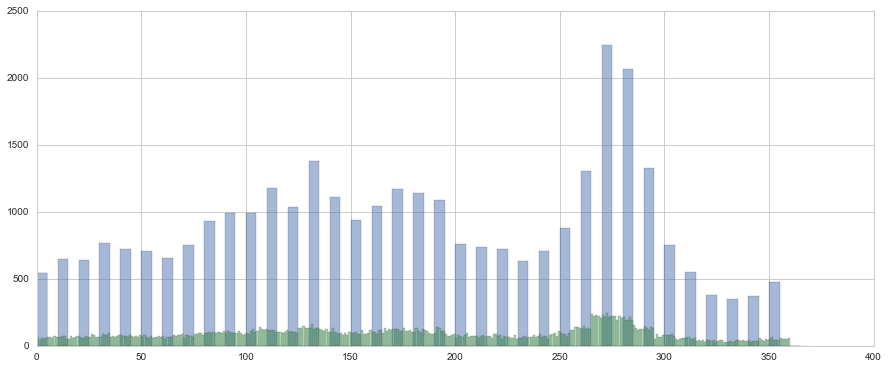

In [29]:
# Randomize the angle degree, to form a better KDE estimation
df['dir_int'] = df['dir']
df = randomize_angle(df, sector_length)

In [30]:
def randomize_speed(df):
    # Round down speed, need more caution
    df['speed_ran'] = df['speed'].apply(lambda x: (x + np.random.uniform(-1,0)) if x > 0 else x)

    bins=np.arange(0, df.speed.max(), 1)
    df['speed'].hist(bins=bins, alpha=0.5,figsize=(15, 6))
    bins=np.arange(0, df.speed.max(), 0.5)
    df['speed_ran'].hist(bins=bins, alpha=0.5,figsize=(15, 6))
    
    df['speed']=df['speed_ran']
    df.drop(['speed_ran'], 1,inplace=True)
    return df

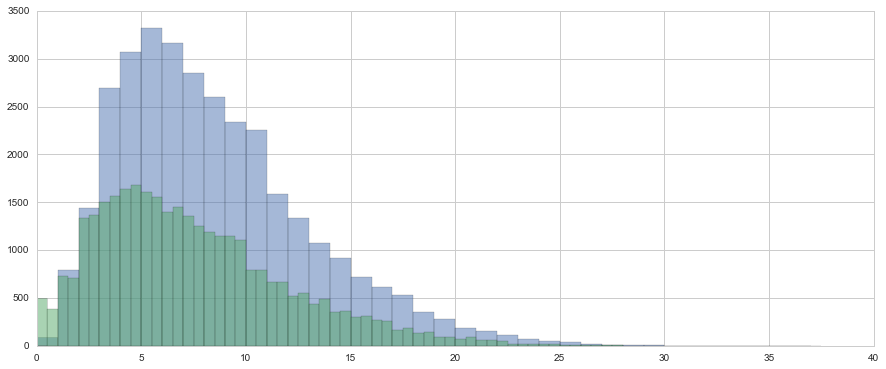

In [31]:
# Each original cell is split between the value, # so the peak is shift left
# e.g. 2 -> (1.5,2), (2,2.5); or 3 -> (2,3)
df['speed_int'] = df['speed']
df = randomize_speed(df)

### 1.4.4 Generate (x,y) from (speed,dir)

-0.801737836674 0.35515538938


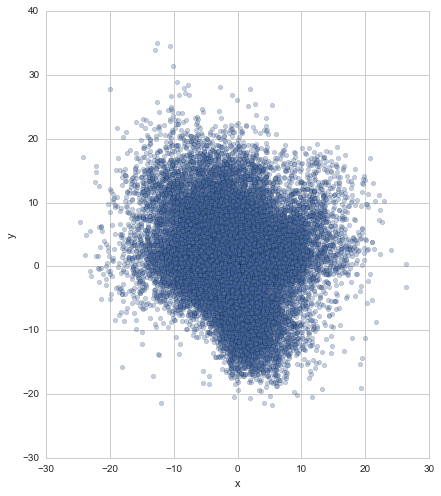

In [32]:
df['x'] = df['speed'] * np.cos(df['dir'] * np.pi / 180.0)
df['y'] = df['speed'] * np.sin(df['dir'] * np.pi / 180.0)
fig, ax = plt.subplots(figsize=(8, 8), dpi=80)
ax.set_aspect('equal')
df.plot(kind='scatter', x='x', y='y', alpha=0.35, ax=ax)
print np.mean(df.x), np.mean(df.y)

# 2. Create input data, i.e. speed_set

In [33]:
# speed_set = np.array(zip(-df.x, -df.y)) # Adjust the direction to match for Cook's paper
speed_set = np.array(zip(df.x, df.y))
speed_angle_set = np.array(zip(df.speed, df.dir))
max_speed = df.speed.max()
number_of_gaussian = 3

In [34]:
fitting_range = []
if knot_unit == True:
    fitting_axis_range = np.arange(-20, 21, 1)
    plot_axis_range = np.arange(-25, 25, 1)
else:
    fitting_axis_range = np.arange(-10, 11, 1)
    plot_axis_range = np.arange(-10, 11, 1)
    
for i in fitting_axis_range:
    for j in fitting_axis_range:
        fitting_range.append([i,j])

original_dim = int(np.sqrt(len(fitting_range))) 

# 3. Kernel Density Estimation

In [35]:
sample = speed_set

In [36]:
# # The bandwidth value would be too radical, so we forsake this approach
# from sklearn.grid_search import GridSearchCV
# grid = GridSearchCV(neighbors.KernelDensity(),
#                     {'bandwidth': np.linspace(0.1, 1.0, 15)},
#                     n_jobs=-1, cv=4) 
# grid.fit(sample)
# print grid.best_params_
# kde = grid.best_estimator_

In [37]:
bandwidth = 1 if knot_unit else 0.5  # for wuhan, 0.4 is better
kde = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample)

points = fitting_range
# very slow if the dataset is too large, e.g. 100,000
# kde returns log prob, need to convert it
kde_result = np.exp(kde.score_samples(points))
print kde_result[:5]
print len(kde_result)

[  1.48840632e-10   5.88451466e-09   8.55865129e-08   4.57936794e-07
   9.01386964e-07]
1681


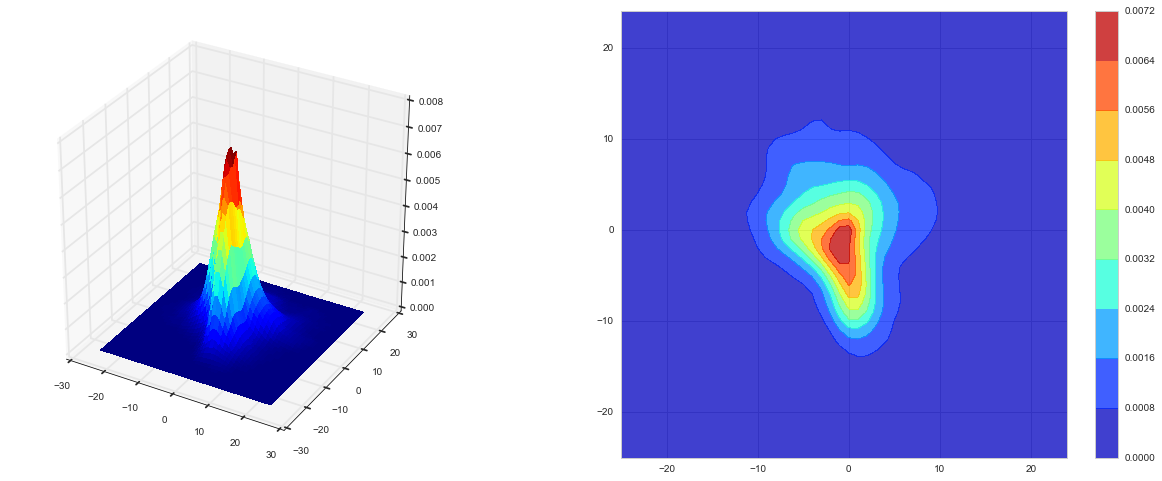

In [38]:
# Plot jPDF
X = Y = plot_axis_range
# Can't work if pass as generate_Z_from_X_Y(X,Y, np.exp(kde.score_samples())), need to use lambda
# see http://stackoverflow.com/questions/21035437/passing-a-function-as-an-argument-in-python
kde_Z = generate_Z_from_X_Y(X,Y, lambda coords: np.exp(kde.score_samples(coords)))

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,kde_Z,ax1)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,kde_Z,ax2)

In [39]:
kde_cdf = cdf_from_pdf(kde_result)

# 4. GMM Estimation, using EM algo

In [40]:
sample= speed_set
clf = mixture.GMM(n_components=number_of_gaussian, covariance_type='full')
clf.fit(sample)

clf.converged_

True

In [41]:
gmm_em_result = read_gmm_em_result(clf, print_result = False)
pretty_print_gmm(gmm_em_result)  

,weight,mean_x,mean_y,sig_x,sig_y,corr
0,0.441477,-0.508155,-3.511546,2.875718,5.027948,-0.478332
1,0.303443,-4.558655,3.654520,5.513243,6.674139,-0.190226
2,0.255080,3.159368,3.122488,6.138480,5.844976,0.016313


GMM Plot Result
0.441477080251 [[-0.50815542 -3.51154629]] [ 2.4109464   5.26662628] -160.441577872
0.255080171388 [[ 3.15936751  3.12248848]] [ 5.83685792  6.14619987] -80.7958915874
0.303442748361 [[-4.55865522  3.65452034]] [ 5.24578232  6.88634512] -157.651789041


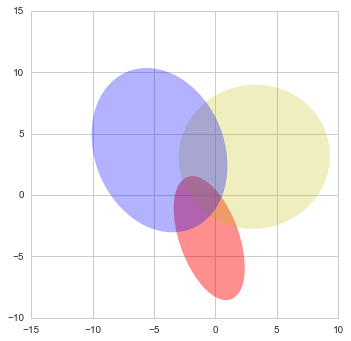

In [42]:
plot_gmm_ellipses(gmm_em_result)

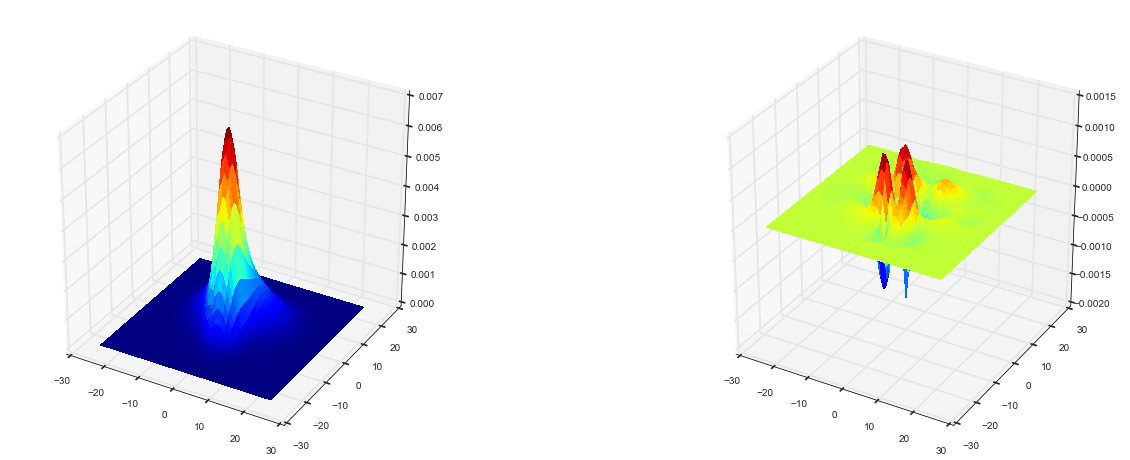

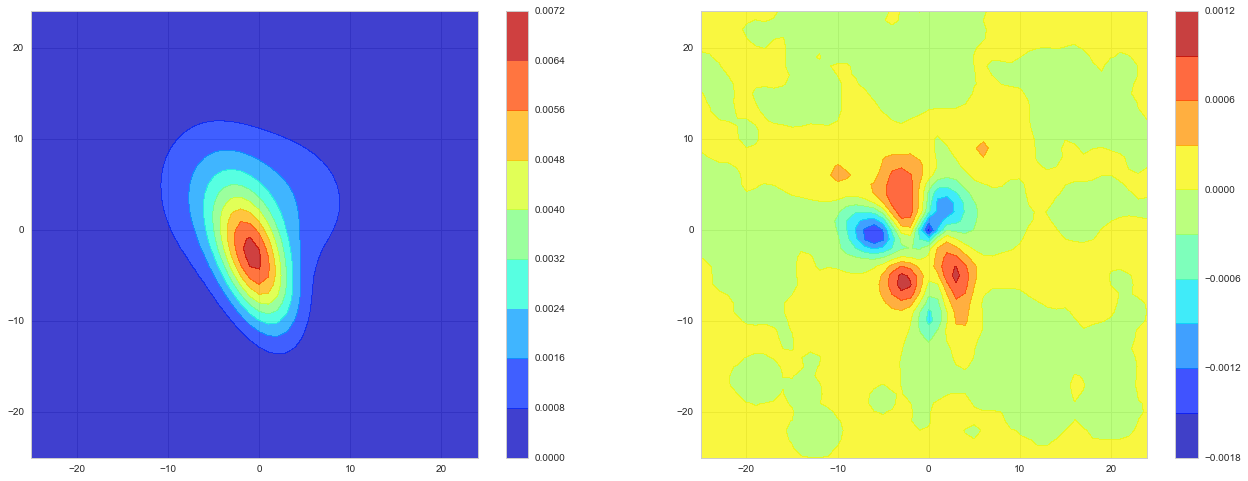

In [43]:
X = Y = plot_axis_range
pdf_Z = generate_Z_from_X_Y(X,Y, lambda coords: np.exp(clf.score_samples(coords)[0]))

def residule_between_kde_and_gmm(points):
    kde_vals = np.exp(kde.score_samples(points))
    gmm_vals = np.exp(clf.score_samples(points)[0])
    return gmm_vals - kde_vals

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2,projection = '3d')
plot_3d_prob_density(X,Y,residual_Z,ax2)
gmm_em_3d_fig = fig

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1)
plot_2d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,residual_Z,ax2)
gmm_em_2d_fig = fig

## GMM, EM VS. KDE

In [44]:
points = fitting_range
gmm_pdf_result = np.exp(clf.score_samples(points)[0])

In [45]:
# put into Pandas to make it looks better
pd.DataFrame([goodness_of_fit_summary(gmm_pdf_result, kde_result, count = len(df))])

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.063719,0.025064,4.882771e-08,0.031203,0.373544,0.961908


# 5. Least Square Prob Estimation

In [46]:
sample = speed_set
points = fitting_range

In [47]:
gmm_em_result = read_gmm_em_result(clf, print_result = False)
pretty_print_gmm(gmm_em_result)             

,weight,mean_x,mean_y,sig_x,sig_y,corr
0,0.441477,-0.508155,-3.511546,2.875718,5.027948,-0.478332
1,0.303443,-4.558655,3.654520,5.513243,6.674139,-0.190226
2,0.255080,3.159368,3.122488,6.138480,5.844976,0.016313


In [48]:
def GMM_fit_score(gmm, kde_result, method = 'square_error'): 
    # 1. Create the GMM PDF
    if not isinstance(gmm[0], np.ndarray):
        gmm = group_gmm_param_from_gmm_param_array(gmm, sort_group = False)
    mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
    # 2. Fit the model using different metrics
    gmm_pdf_result = mixed_model_pdf(points)
    if method == 'square_error':
        # 2.1 Square error
        error_array = np.power(gmm_pdf_result - kde_result,2)
        result = mse_log = np.log(np.average(error_array))
    elif method == 'chi_square':
        # 2.2 Chi square
        error_array = np.power(gmm_pdf_result - kde_result,2)
        # unable to * count = 43412, use normalized chi square
        result = chi_square_stat = np.log(sum(error_array/gmm_pdf_result))
    elif method == 'K_S':
        # 2.3 K-S statistc
        gmm_cdf = cdf_from_pdf(gmm_pdf_result)
        diff = np.absolute(gmm_cdf - kde_cdf)
        result = KS_stat = np.amax(diff)
    return result

# from GMM,EM 
# GMM format: weight, meanx, meany, sigx, sigy, rho
x0 = gmm_em_result

cons = [
    # sum of every 6th element, which is the fraction of each gaussian
    {'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},
    # limit the width/height ratio of elliplse, optional
#     {'type': 'ineq', 'fun': lambda x: width_height_ratios_set(x) - 1/3},
#     {'type': 'ineq', 'fun': lambda x: 3 - width_height_ratios_set(x)},
]

bonds = [(0., 0.99),(-30, 30),(-30, 30),(0., 30),(0., 30),(-0.99, 0.99)]*int(len(x0)/6)

result = sp.optimize.minimize(
    lambda x0: GMM_fit_score(x0, kde_result, 'chi_square'),
    x0,
    bounds = bonds,
    constraints=cons,
    tol = 0.000000000001,
    options = {"maxiter": 500})
result

     fun: -3.6290354172576538
     jac: array([ -1.17142719e+00,   0.00000000e+00,   8.94069672e-08,
         4.17232513e-07,   1.78813934e-07,   4.17232513e-07,
        -1.17142510e+00,  -1.49011612e-07,   8.94069672e-08,
         0.00000000e+00,  -5.96046448e-08,  -2.08616257e-07,
        -1.17142582e+00,  -1.19209290e-07,  -1.49011612e-07,
        -1.19209290e-07,  -1.78813934e-07,   2.98023224e-08,
         0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 1333
     nit: 66
    njev: 66
  status: 0
 success: True
       x: array([ 0.3285329 , -0.11872891, -5.01384987,  2.65630577,  4.80047689,
       -0.46316501,  0.23027574, -2.13582415,  0.68638878,  4.72668821,
        2.84955829,  0.15772031,  0.44119136, -0.5136702 ,  4.23221153,
        7.58137328,  7.04050144, -0.18288543])

## LRMSE VS. KDE

In [49]:
kde_result[:5]

array([  1.48840632e-10,   5.88451466e-09,   8.55865129e-08,
         4.57936794e-07,   9.01386964e-07])

In [50]:
gmm = group_gmm_param_from_gmm_param_array(result.x, sort_group = True)
mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
gmm_pdf_result = mixed_model_pdf(points)

pretty_print_gmm(gmm)

,weight,mean_x,mean_y,sig_x,sig_y,corr
0,0.441191,-0.513670,4.232212,7.581373,7.040501,-0.182885
1,0.328533,-0.118729,-5.013850,2.656306,4.800477,-0.463165
2,0.230276,-2.135824,0.686389,4.726688,2.849558,0.157720


GMM Plot Result
0.441191362722 [[-0.5136702   4.23221153]] [ 6.55672475  8.00345187] -123.974148019
0.328532895473 [[-0.11872891 -5.01384987]] [ 2.26073539  4.99896131] -161.771808963
0.230275741805 [[-2.13582415  0.68638878]] [ 2.79453832  4.75942427] -81.6833188606


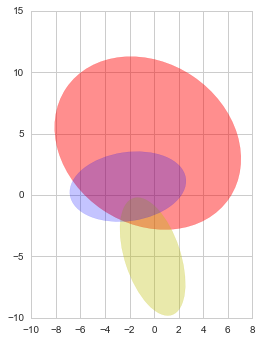

In [51]:
plot_gmm_ellipses(gmm)

## Goodness-of-fit indicators

In [52]:
pd.DataFrame(
    [goodness_of_fit_summary(gmm_pdf_result, kde_result, count = len(df))])

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.026542,0.009045,1.944321e-08,0.01969,0.235718,0.984832


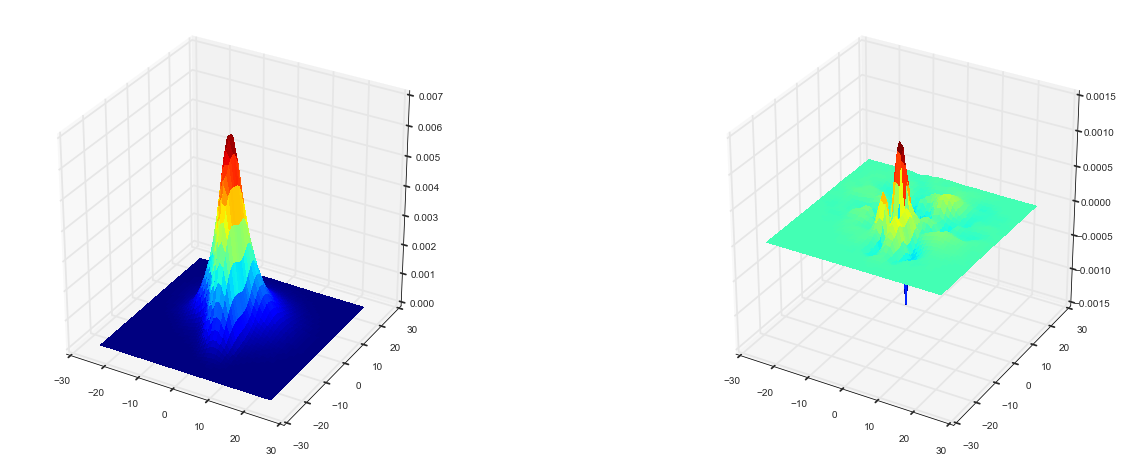

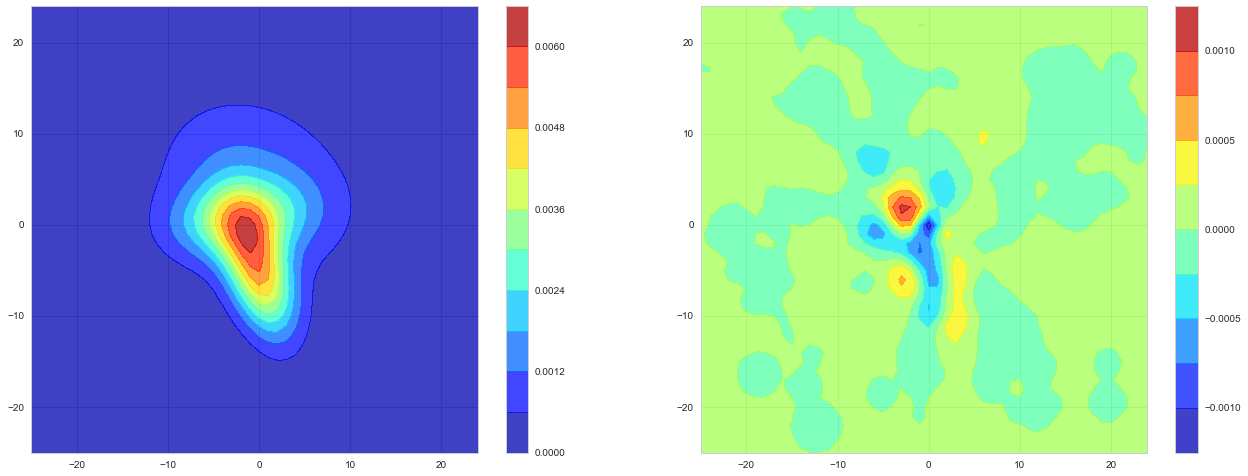

In [53]:
X = Y = plot_axis_range
pdf_Z = generate_Z_from_X_Y(X,Y, mixed_model_pdf)# passing a function as an argument

def residule_between_kde_and_gmm(points):
    kde_vals = np.exp(kde.score_samples(points))
    gmm_vals = mixed_model_pdf(points)
    return gmm_vals - kde_vals

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2,projection = '3d')
plot_3d_prob_density(X,Y,residual_Z,ax2)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1)
plot_2d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,residual_Z,ax2)

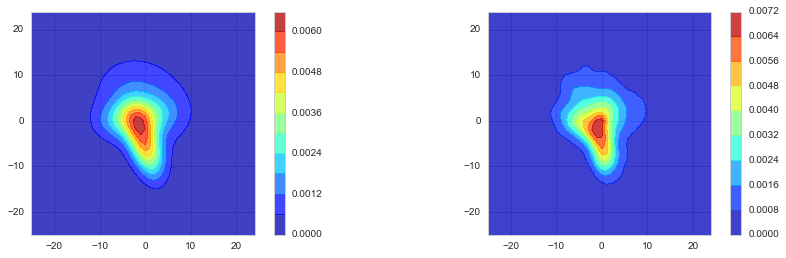

In [54]:
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(1,2,1)
plot_2d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,kde_Z,ax2)

In [55]:
def f(V,theta):
    return (mixed_model_pdf([[V*cos(theta),V*sin(theta)]]))*V

x_vals_OEN3_LMSE  = np.arange(0, max_speed, 0.5)
y_vals_OEN3_LMSE =[integrate.nquad(f, [[0, x_val],[0, 2*np.pi]]) for x_val in x_vals_OEN3_LMSE ]

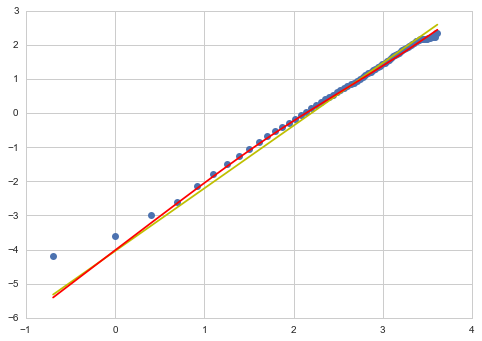

In [56]:
sample = df.speed
x = np.arange(0, max_speed, 0.5)

# 1. Plot v-p points, empirical distribution
ecdf = sm.distributions.ECDF(sample)
y = ecdf(x)
plt.plot(np.log(x), np.log(-np.log(1-y)),'o')

# 2. Weibull distribution
w_scale, c_shape = weibull_params[1], weibull_params[3]
qz=np.exp(-(x/c_shape)**w_scale)
plt.plot(np.log(x), np.log(-np.log(qz)),'-', color = 'y')

# 3. OEN3 distribution, LMSE
x, y_ = x_vals_OEN3_LMSE, y_vals_OEN3_LMSE
y = np.array(zip(*y_)[0])
plt.plot(np.log(x), np.log(-np.log(1-y)),'-', color = 'r')

plt.show()

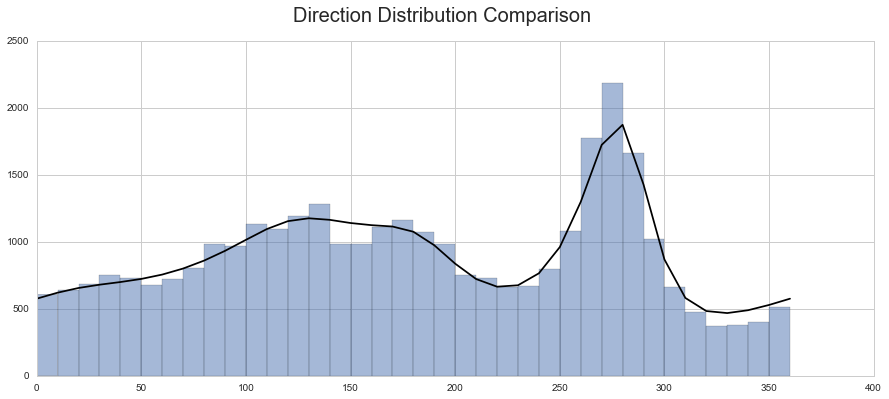

In [57]:
# Calculate Angle Distribution
x_vals = np.linspace(0,2*np.pi, num=36+1)
y_vals_ =[integrate.nquad(f, [[0, inf],[x_val-np.pi/36, x_val+np.pi/36]]) for x_val in x_vals]

# 1. integrate.nquad returns 2 vaule, result, abserr. Need to abstract the first to plot
# 2. * length of data size, to adjust the plot space
y_vals = np.array(zip(*y_vals_)[0])*len(df['dir']) 

bins=np.arange(0, 360 + 1, 10)
df['dir'].hist(bins=bins, alpha=0.5,figsize=(15, 6))

plt.plot(x_vals/np.pi*180, y_vals,'-', color='black')
plt.suptitle('Direction Distribution Comparison', fontsize = 20)
plt.show()

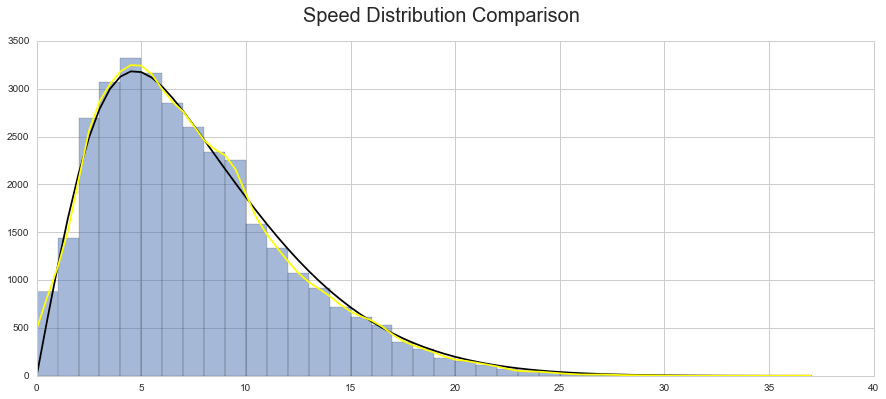

In [58]:
# Calculate Speed Distribution
# 1. GMM Model
x_vals = np.arange(0, max_speed, 0.5)
y_vals_ =[integrate.nquad(f, [[x_val-0.5, x_val+0.5],[0, 2*np.pi]]) for x_val in x_vals]
y_vals = np.array(zip(*y_vals_)[0])*len(df.speed)
plt.plot(x_vals, y_vals,'-', color='black')

# 2. Observation
bins = np.arange(0, max_speed, 1)
df['speed'].hist(bins=bins, alpha=0.5,figsize=(15, 6))

# 3. 1d KDE
sample = np.array(df.speed).reshape(-1, 1)
kde_temp = neighbors.KernelDensity(bandwidth=0.5).fit(sample) 
y_vals = [np.exp(kde_temp.score_samples(x_val))*len(sample) for x_val in x_vals]
plt.plot(x_vals, y_vals,'-', color='yellow')

plt.suptitle('Speed Distribution Comparison', fontsize = 20)
plt.show()

In [59]:
# Calculate Speed Distribution
def model_data_comparison(df, original_incre = 10, incre = 10):
    start, end = -original_incre/2 + incre/2, 360
    max_diff_array = []
    for angle in np.arange(start, end, incre):
        angle_radian, incre_radian = radians(angle), radians(incre)  

        # Select data from observation
        start_angle, end_angle = angle-incre/2, angle+incre/2
        if start_angle <0:
            sub_df= df[((df['dir'] >= start_angle%360) & (df['dir'] <= 360)) | 
                       ((df['dir'] >= 0) & (df['dir'] <= end_angle))] 
        else:
            sub_df= df[(df['dir'] >= start_angle) & (df['dir'] <= end_angle)] 
        max_speed = sub_df.speed.max()
        
        # 1. Count comparison
        # 1.1. Data Count
        bins = np.arange(0, max_speed, 1)
        fig = plt.figure(figsize=(22,4))
        ax1 = fig.add_subplot(1,4,1)        
        sub_df['speed'].hist(bins=bins, alpha=0.5)
        
        # 1.2. Model Count
        x_vals = np.arange(0, max_speed, 0.5)
        y_vals_ =[integrate.nquad(f, 
                                  [[x_val-0.5, x_val+0.5],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
                  for x_val in x_vals]
        y_vals = np.array(zip(*y_vals_)[0])*len(df.speed)
        plt.plot(x_vals, y_vals,'-', color='black')
    
        title = str(angle) + ' (' + str(start_angle) + '-' +str(end_angle) + ')'
        plt.suptitle(title+' Degree Speed Distribution Comparison', fontsize = 15)
        
        # 2. CDF, Weibull plot comparison
        # 2.1. Data's empirical distribution
        sample = sub_df.speed
        x =np.arange(0, max(sample), 0.5)
        ecdf = sm.distributions.ECDF(sample)
        y_cdf = ecdf(x)
        
        # 2.2. Model
        y_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
             for x_val in x]
        direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
        y_gmm = np.array(zip(*y_)[0])/direction_prob[0]
                
        # 2.3.1. Plot in ordinary axis
        ax3 = fig.add_subplot(1,4,2)
        plt.plot(x, y_cdf,'o')
        plt.plot(x, y_gmm,'-', color = 'r')
        
        # 2.3.2. P-P Plot
        ax2 = fig.add_subplot(1,4,3)
        p_line = np.linspace(0, 1)
        plt.plot(y_gmm,y_cdf, 'o')
        plt.plot(p_line, p_line,'-')
        
        # 2.3.3. Plot in Weibull axis
        ax4 = fig.add_subplot(1,4,4)
        plt.plot(np.log(x), np.log(-np.log(1-y_cdf)),'o')
        plt.plot(np.log(x), np.log(-np.log(1-y_gmm)),'-', color = 'r')
        plt.show()
        
        diff = abs(y_cdf - y_gmm)
        max_diff_array.append([angle, diff.max(), x[diff.argmax()]])
        print diff.max(), x[diff.argmax()], y_gmm[diff.argmax()]
    return max_diff_array

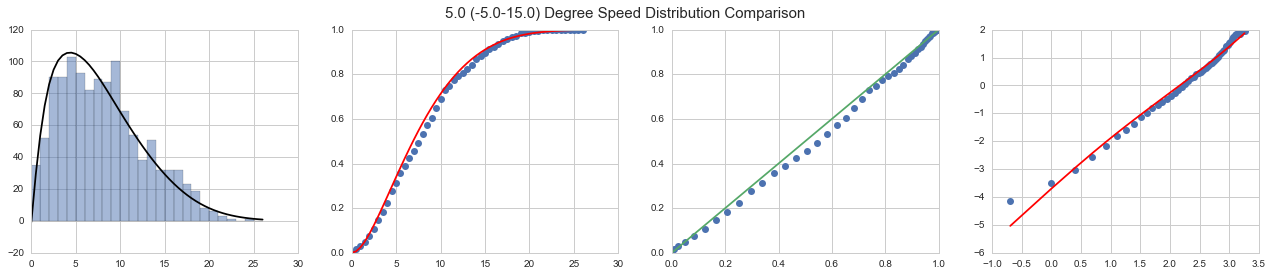

0.0535713067069 7.5 0.545594816363


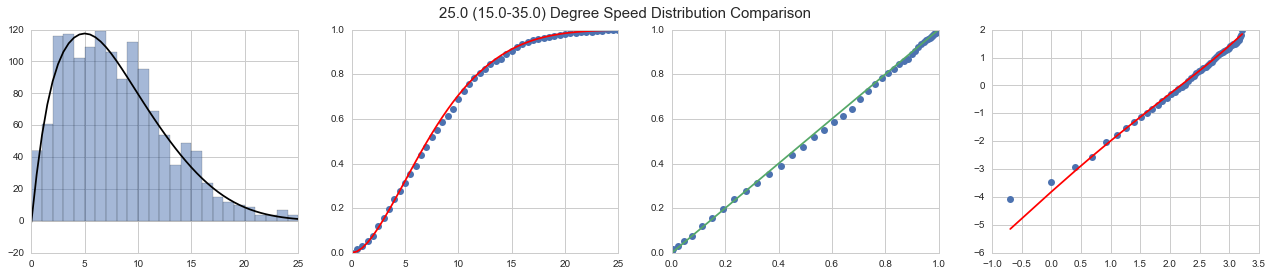

0.0323480051881 9.5 0.675154525386


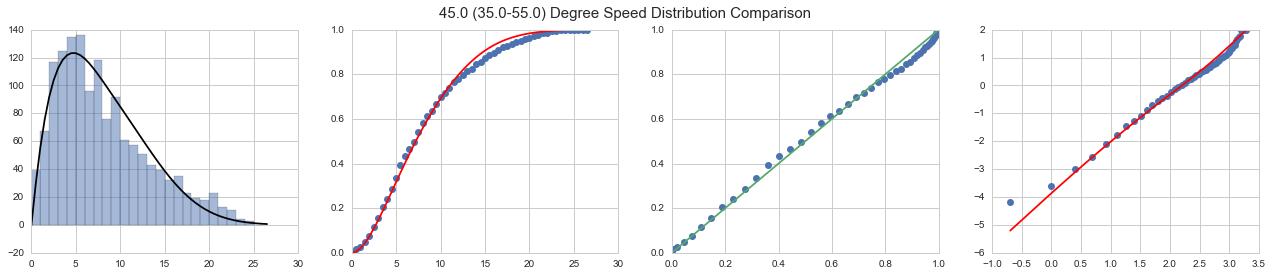

0.0349913552078 16.0 0.930388844748


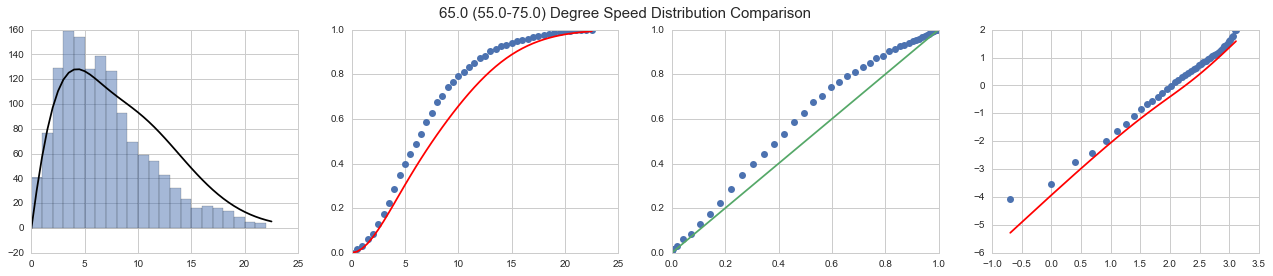

0.147777863768 8.0 0.528817880913


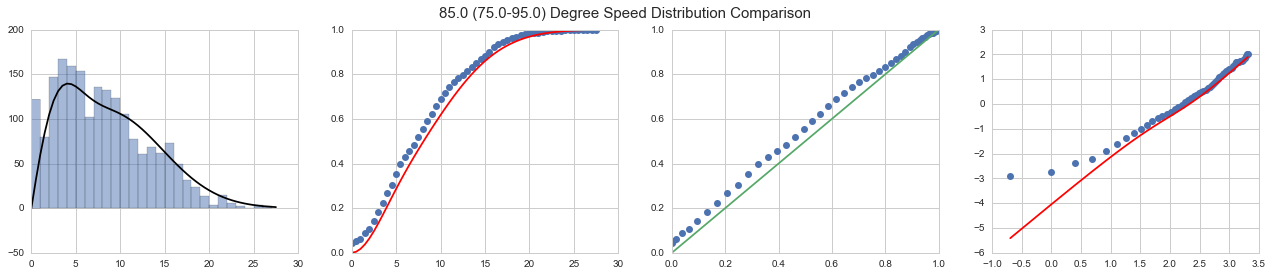

0.0748793433302 5.5 0.322936569306


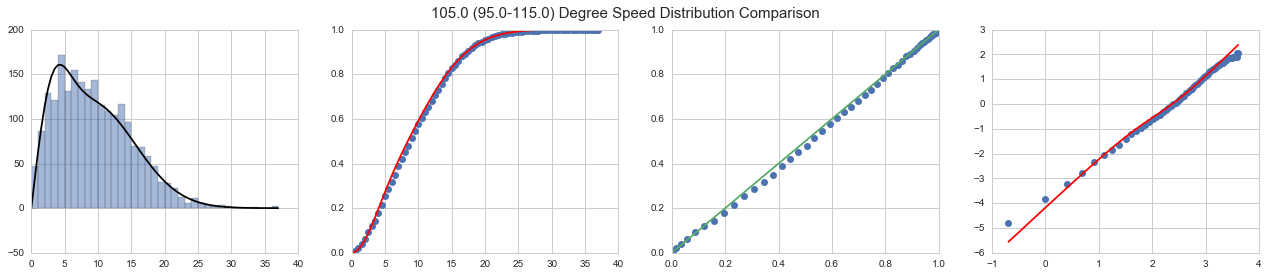

0.0290900619433 6.5 0.3785153493


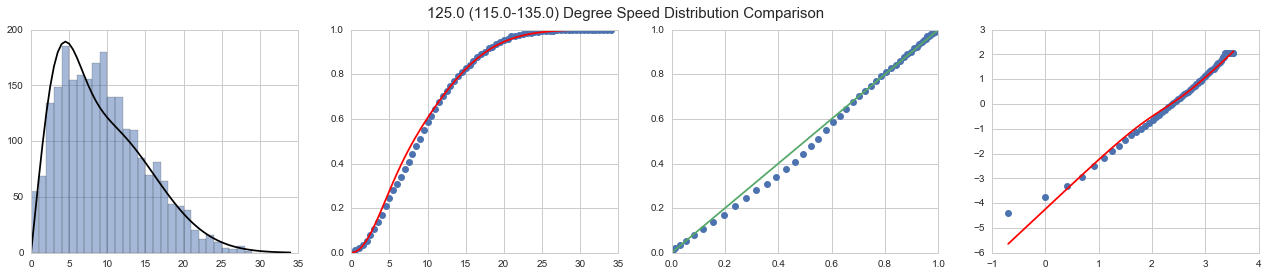

0.053586353832 6.5 0.392864661588


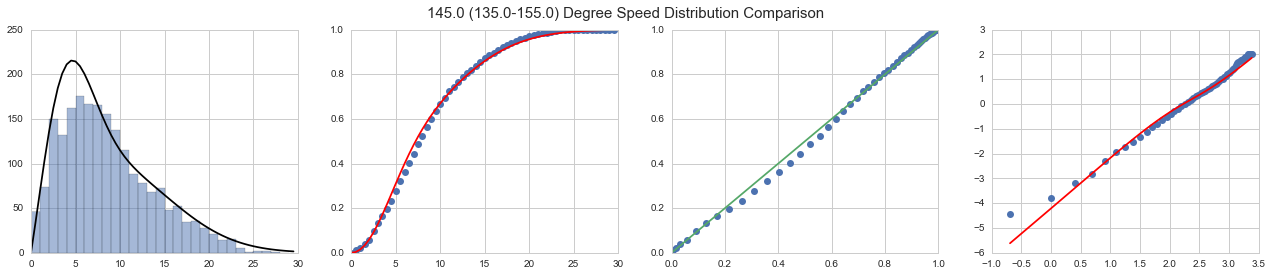

0.0400167304432 6.5 0.443242536895


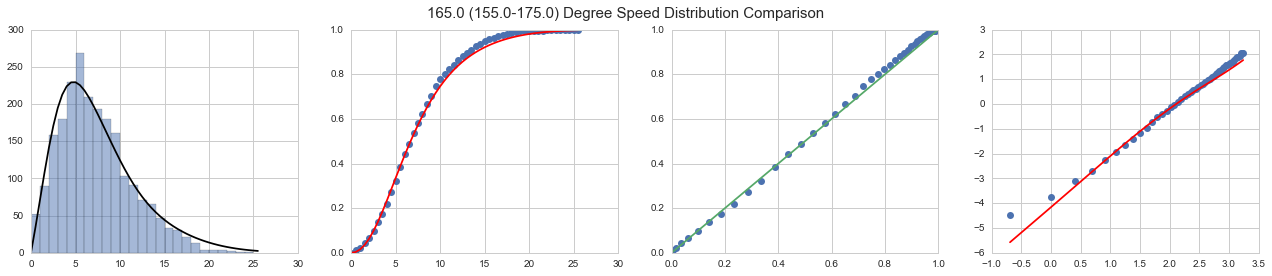

0.0305812948432 10.0 0.746494517431


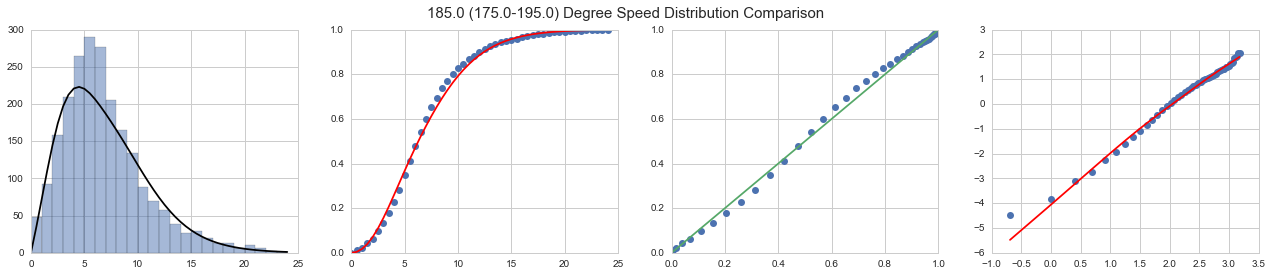

0.0441349969121 8.5 0.692966842478


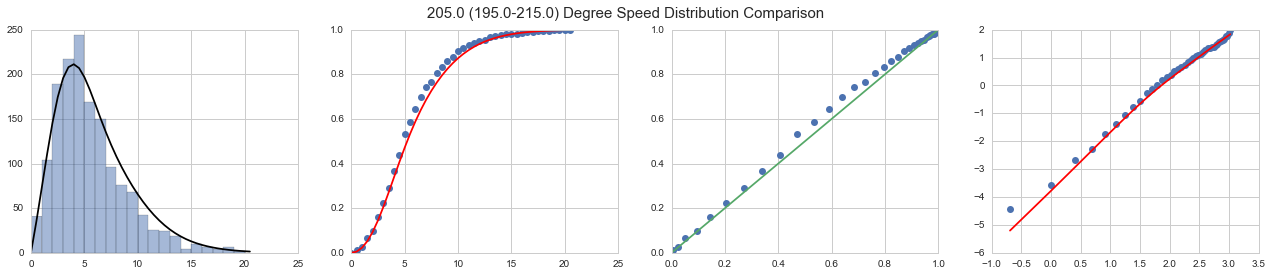

0.0598879874925 6.5 0.639244767678


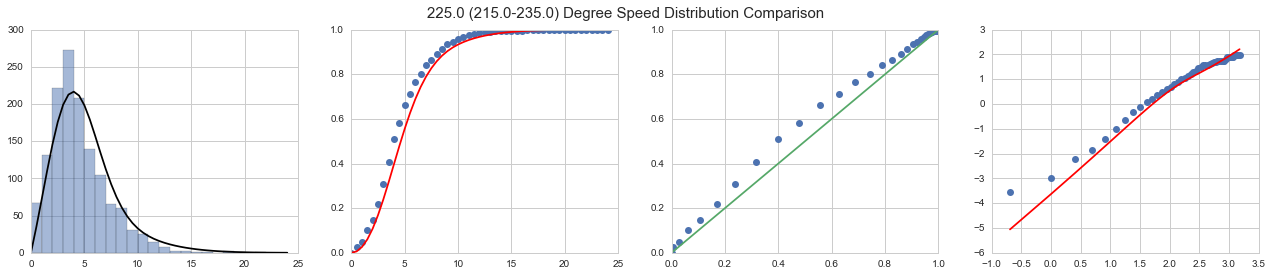

0.110599995799 4.0 0.397862108689


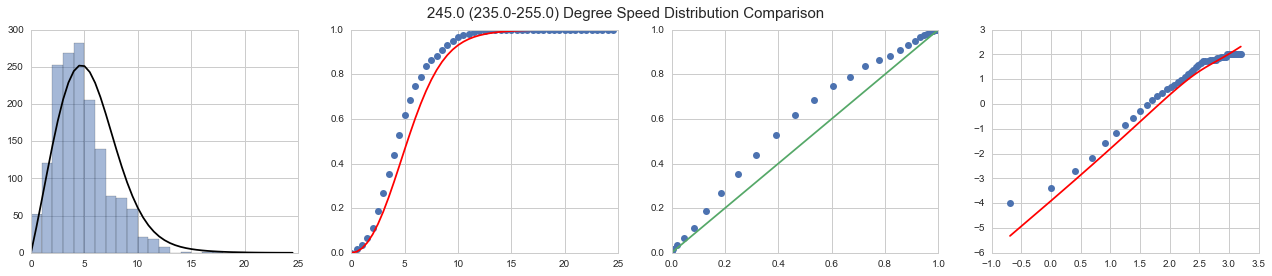

0.153102834392 5.0 0.463300951097


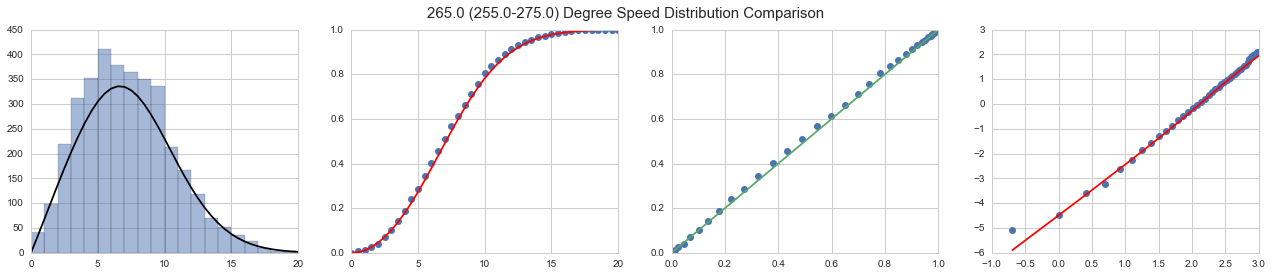

0.0243633974995 6.0 0.378898694739


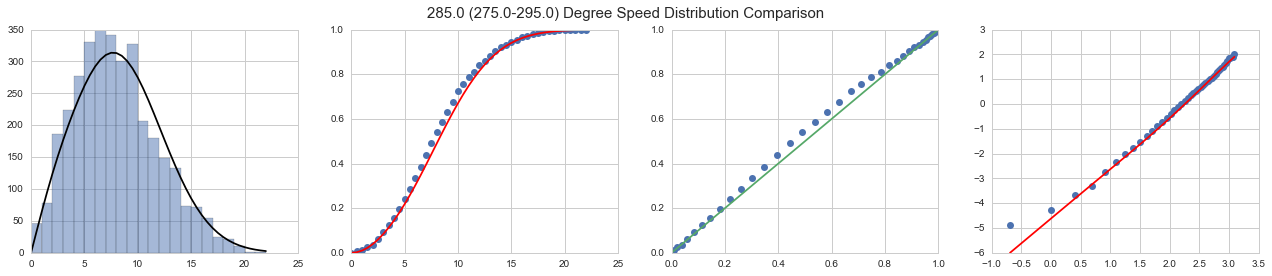

0.0549179120671 10.0 0.670693641131


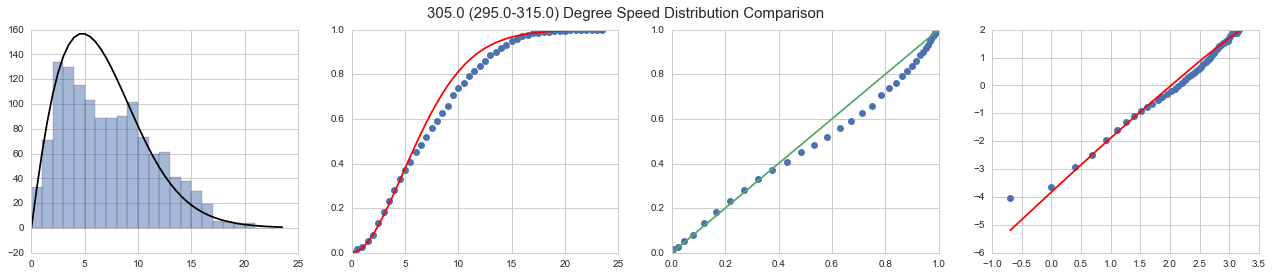

0.0909854744906 9.0 0.748920759545


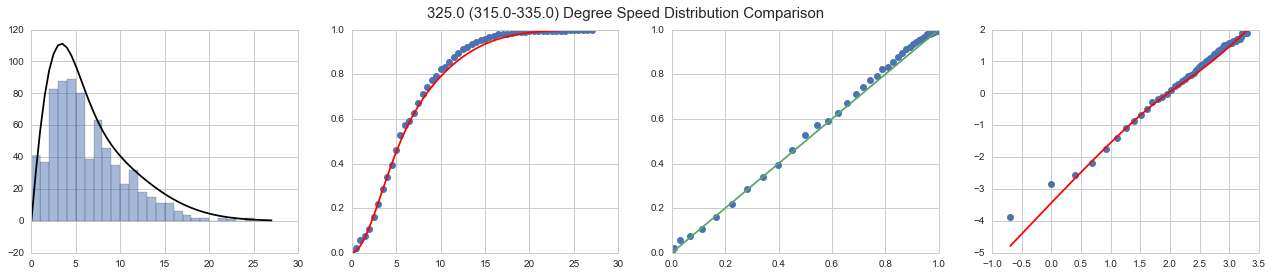

0.0348868825527 12.5 0.877561817858


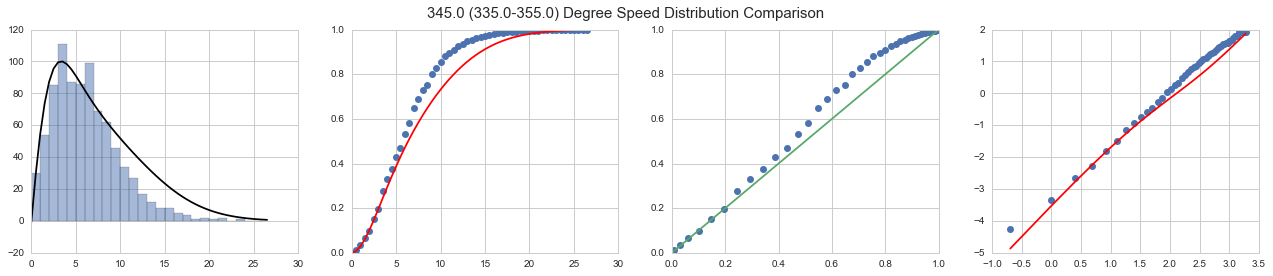

0.128203751302 10.5 0.755599065599


In [60]:
if cn_database:
    model_data_comparison(df, 22.5, 22.5)
else: 
    max_diff_array = model_data_comparison(df, 10, 20)

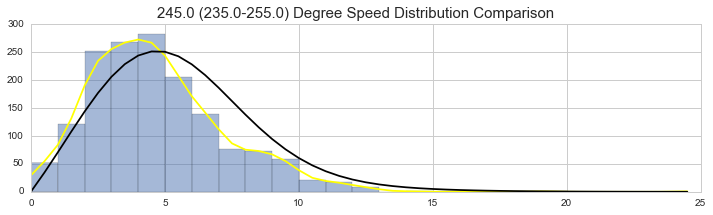

In [67]:
max_diff_element = max(max_diff_array, key=lambda x: x[1])
angle =  max_diff_angle = max_diff_element[0]
incre = 20

angle_radian, incre_radian = radians(angle), radians(incre)  
x_vals = np.arange(0, max_speed, 0.5)

# Select data from observation
start_angle, end_angle = angle-incre/2, angle+incre/2
sub_df= df[(df['dir'] >= start_angle) & (df['dir'] <= end_angle)] 
max_speed = sub_df.speed.max()

# 1. Observation
bins = np.arange(0, max_speed, 1)
sub_df['speed'].hist(bins=bins, alpha=0.5,figsize=(12, 3))

# 2. 1d KDE 
sample = np.array(sub_df.speed).reshape(-1, 1)
sub_kde = neighbors.KernelDensity(bandwidth=0.5).fit(sample) 
y_vals = [np.exp(sub_kde.score_samples(x_val))*len(sample) for x_val in x_vals]
plt.plot(x_vals, y_vals,'-', color='yellow')

# 3. GMM
y_vals_ =[integrate.nquad(f, [[x_val-0.5, x_val+0.5],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x_vals]
y_vals = np.array(zip(*y_vals_)[0])*len(df) 
plt.plot(x_vals, y_vals,'-', color='black')

title = str(angle) + ' (' + str(start_angle) + '-' +str(end_angle) + ')'
plt.suptitle(title+' Degree Speed Distribution Comparison', fontsize = 15)
plt.show()

## Bootstrap, to see the variance of each sector

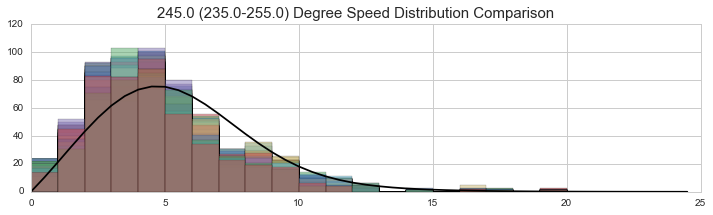

In [68]:
x_vals = np.arange(0, max_speed, 0.5)
y_vals_ =[integrate.nquad(f, [[x_val-0.5, x_val+0.5],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x_vals]
y_vals = np.array(zip(*y_vals_)[0])*len(df.speed)*0.3
plt.plot(x_vals, y_vals,'-', color='black')

bins = np.arange(0, max_speed, 1)
for i in xrange(1,100):
    sub_df_resampled = sub_df.sample(frac=0.3, replace=True)
    sub_df_resampled['speed'].hist(bins=bins, alpha=0.5,figsize=(12, 3))

title = str(angle) + ' (' + str(start_angle) + '-' +str(end_angle) + ')'
plt.suptitle(title+' Degree Speed Distribution Comparison', fontsize = 15)

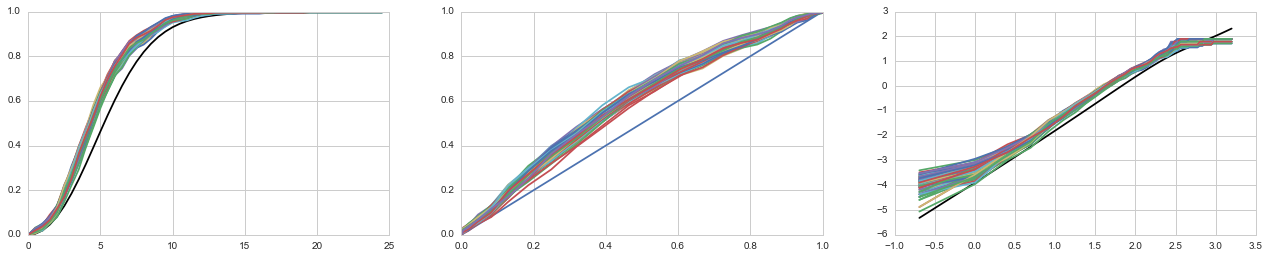

In [69]:
fig = plt.figure(figsize=(22,4))

x = np.arange(0, max_speed, 0.5)
y_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x]
direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_gmm = np.array(zip(*y_)[0])/direction_prob[0]

ax1 = fig.add_subplot(1,3,1) 
plt.plot(x, y_gmm,'-', color = 'black')

ax2 = fig.add_subplot(1,3,2) 
p_line = np.linspace(0, 1)
plt.plot(p_line, p_line,'-')

ax3 = fig.add_subplot(1,3,3) 
plt.plot(np.log(x), np.log(-np.log(1-y_gmm)),'-', color = 'black')

for i in xrange(1,100):
    sub_df_resampled = sub_df.sample(frac=0.5, replace=True)
    
    sample = sub_df_resampled.speed
    ecdf = sm.distributions.ECDF(sample)
    y_cdf = ecdf(x)

    ax1 = fig.add_subplot(1,3,1) 
    plt.plot(x, y_cdf,'-')

    ax2 = fig.add_subplot(1,3,2) 
    plt.plot(y_gmm, y_cdf, '-')

    ax3 = fig.add_subplot(1,3,3) 
    plt.plot(np.log(x), np.log(-np.log(1-y_cdf)),'-')

# Cross Validation, to check the number of ellipse to be fitted

In [64]:
from sklearn.cross_validation import train_test_split, KFold
    
def fit_gmm(df, number_of_gaussian = 3, fit_method = 'square_error', print_result = False):
    # 1. Create Input, speed_set
    sample = sub_speed_set = np.array(zip(df.x, df.y))
    points = fitting_range
    
    # 2. KDE + EM fitting
    kde = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample) 
    kde_result = np.exp(kde.score_samples(points))

    clf = mixture.GMM(n_components=number_of_gaussian, covariance_type='full')
    clf.fit(sample)
    gmm_em_result = read_gmm_em_result(clf, print_result)
        
    # 3. GMM fitting
    x0 = gmm_em_result
    bonds = [(0., 0.99),(-30, 30),(-30, 30),(0., 30),(0., 30),(-0.99, 0.99)]*int(len(x0)/6)
    cons = [{'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},]
 
    result = sp.optimize.minimize(
        lambda x0: GMM_fit_score(x0, kde_result, method=fit_method),
        x0,
        bounds = bonds,
        constraints = cons,
        tol = 0.000000000001,
        options = {"maxiter": 500})  
    
    # 4. Returns
    gmm = group_gmm_param_from_gmm_param_array(result.x)       
    mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
    gmm_pdf_result = mixed_model_pdf(points)
    
    return {
        'gmm' : gmm,
        'kde_result': kde_result,
        'gmm_pdf_result': gmm_pdf_result,
        'number_of_iteration': result.nit}

In [65]:
## 5-fold cross validation
CV_result_all =[]
number_of_fold = 4
print 'Number of train/test dataset', len(df)*(number_of_fold-1)/number_of_fold, len(df)/number_of_fold

for number_of_gaussian in xrange(1,6):
    print '  '
    print 'Number of gaussian', number_of_gaussian
    
    kf = KFold(len(df), n_folds=number_of_fold, shuffle=True) # each number of gaussian, fit 4 times

    CV_result = []
    for train_index, test_index in kf:
        sub_df = df.iloc[train_index]
        sub_df_test = df.iloc[test_index]

        # 1. Train
        result = fit_gmm(sub_df, number_of_gaussian, fit_method = 'chi_square')
        gmm_pdf_result_train = result['gmm_pdf_result']

        # 2. Validate
        # GMM from Train - KDE from Test
        sample = np.array(zip(sub_df_test.x, sub_df_test.y))
        kde_test = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample) 
        kde_result_test = np.exp(kde_test.score_samples(points))

        gof_train = goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result, 
                                            count = len(sub_df))
        gof_test =  goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result_test, 
                                            count = len(sub_df_test))
        
        display(pd.DataFrame([gof_train, gof_test], index=["gof_train", "gof_test"]))
        
        CV_result.append(gof_test)
        
    CV_result_all.append(CV_result)

Number of train/test dataset 24539.25 8179.75
  
Number of gaussian 1


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.338776,0.046080,2.071809e-07,0.064274,0.769455,0.838373
gof_test,0.374139,0.044264,2.156500e-07,0.066007,0.785397,0.835726


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.356227,0.046589,2.047077e-07,0.063889,0.764848,0.840302
gof_test,0.464239,0.046109,2.054605e-07,0.063484,0.765958,0.839209


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.344903,0.045421,2.066567e-07,0.064192,0.768481,0.838782
gof_test,0.364292,0.045929,2.081214e-07,0.064650,0.771420,0.837407


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.355121,0.047395,2.070040e-07,0.064246,0.769126,0.838511
gof_test,0.393774,0.050632,2.131592e-07,0.064036,0.780184,0.832575


  
Number of gaussian 2


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.057850,0.024524,5.247699e-08,0.032348,0.387251,0.959061
gof_test,0.069294,0.024016,6.173769e-08,0.034391,0.419649,0.952441


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.057814,0.025749,5.319693e-08,0.032569,0.389898,0.9585
gof_test,0.061547,0.025032,4.695391e-08,0.031321,0.366395,0.9629


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.057882,0.027730,5.229381e-08,0.032291,0.386575,0.959204
gof_test,0.073334,0.034779,6.168210e-08,0.033807,0.419600,0.951859


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.057871,0.027242,5.380295e-08,0.032754,0.392113,0.958027
gof_test,0.079373,0.034900,5.884378e-08,0.033649,0.410585,0.954678


  
Number of gaussian 3


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.026647,0.009450,1.955908e-08,0.019748,0.236419,0.984741
gof_test,0.038031,0.010309,2.351055e-08,0.021370,0.259512,0.981714


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.026625,0.007794,1.879384e-08,0.019358,0.231748,0.985338
gof_test,0.041254,0.007624,2.273095e-08,0.021404,0.254548,0.982176


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.026616,0.008044,1.942923e-08,0.019683,0.235633,0.984843
gof_test,0.039474,0.011756,2.464331e-08,0.021380,0.265376,0.981077


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.026703,0.010842,2.036538e-08,0.020151,0.241243,0.984112
gof_test,0.034229,0.016048,2.272728e-08,0.021344,0.254864,0.982214


  
Number of gaussian 4


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.018611,0.005730,1.343592e-08,0.016368,0.195948,0.989518
gof_test,0.044416,0.008844,1.753321e-08,0.017701,0.224073,0.986532


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.018529,0.008655,1.485812e-08,0.017212,0.206058,0.988409
gof_test,0.031602,0.016574,1.972189e-08,0.020707,0.237205,0.984378


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.019156,0.007856,1.490320e-08,0.017238,0.206371,0.988374
gof_test,0.031815,0.009847,1.960983e-08,0.019660,0.236630,0.984853


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.018516,0.007295,1.456375e-08,0.017041,0.204007,0.988638
gof_test,0.029349,0.011528,1.995788e-08,0.019249,0.238864,0.984462


  
Number of gaussian 5


KeyboardInterrupt: 

In [ ]:
for idx, gof_group in enumerate(CV_result_all):
    print 'number of gaussian', idx+1
    display(pd.DataFrame(gof_group))

In [ ]:
mean_gof_all = []
for idx, gof_group in enumerate(CV_result_all):
    mean_gof = np.mean(pd.DataFrame(gof_group))
    mean_gof_all.append(mean_gof)
mean_gof_all = pd.DataFrame(mean_gof_all)
mean_gof_all

In [ ]:
x = np.arange(1,6)
for column in ['R_square','Chi_square', 'K_S']:
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 3)
    plt.plot(x, mean_gof_all[column],'-')
    plt.suptitle(column)
    plt.show()